In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
#sys.path.append('/home/jma819/post_cmfe_analysis')
sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf
import scipy.spatial.distance as dist
import itertools
import math
import warnings
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
warnings.filterwarnings(action='once')

/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of 

In [2]:
reload(utils_jjm)
reload(dlc_utils)

<module 'dlc_utils' from '/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/dlc_utils.py'>

In [3]:
cnmfe_file_key = pd.read_csv('/Volumes/My_Passport/dlc_analysis/behavcamvideos/open_field_miniscope/cnmfe_key.csv')
#cnmfe_file_key = pd.read_csv('/projects/p30771/dlc_analysis/openfield_dlc_output/cnmfe_file_key.csv')

In [6]:
cnmfe_base_dir = '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/'
#cnmfe_base_dir = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/'
wt_CNMFE_file = ['29-Jan_12_35_06_out.mat','30-Mar_20_39_05_out.mat', '30-Mar_20_45_16_out.mat', '27-Feb_17_33_59_out.mat', '22-Mar_22_52_02_out.mat',
                 '28-Feb_16_10_05_out.mat', '27-Feb_17_32_15_out.mat', '28-Feb_16_21_21_out.mat', '25-Mar_13_27_27_out.mat',
                 '25-Mar_14_22_02_out.mat', '25-Mar_14_22_44_out.mat', '26-Mar_18_33_55_out.mat', '27-Mar_00_26_12_out.mat', '27-Mar_00_48_46_out.mat']

ko_CNMFE_files = ['30-Jan_16_54_31_out.mat','30-Jan_14_00_19_out.mat','31-Jan_01_43_49_out.mat','31-Jan_00_12_24_out.mat','31-Mar_13_28_15_out.mat', '29-Mar_21_42_20_out.mat', 
                  '13-Apr_17_57_40_out.mat', '29-Mar_14_27_55_out.mat', '13-Apr_16_01_20_out.mat',
                 '13-Apr_16_11_27_out.mat', '29-Mar_13_39_44_out.mat']

In [7]:
tracking_files = ['/Volumes/My_Passport/dlc_analysis/behavcamvideos/open_field_miniscope/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in ko_CNMFE_files] 
#tracking_files = ['/projects/p30771/dlc_analysis/openfield_dlc_output/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 

In [8]:
CNMFE_dir_paths_list = [str(cnmfe_base_dir+fname) for fname in ko_CNMFE_files]
#CNMFE_dir_paths_list

In [9]:
binning_time = 1 # seconds 
body_part_for_tracking = 'tail_base' #
number_of_bins = 50 #
polynomial_degree = 2 #

grouped_raw_data = {}
success = []
failed = []
for CNMFE_file, tracking_file in zip(CNMFE_dir_paths_list, tracking_files):
    #print(CNMFE_file)
    #print(tracking_file)
    try:
        # load cell fluorescence 
        cell_fluorescence = sio.loadmat(CNMFE_file)
        C_timedelta = utils_jjm.create_fluorescence_time_delta(cell_fluorescence['C'])
        C_normalized = C_timedelta.apply(utils_jjm.normalize).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_z_scored = C_timedelta.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_normalized_z_scored = C_normalized.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_normalized)-1)*(1/20), len(C_normalized)), unit='s'), drop=True)
        # create tracking time deltas
        interpolated = utils_jjm.prepare_timedelta_dfs(tracking_file)
        #load spatial components by session
        com_df, spatial_components = utils_jjm.return_spatial_info(CNMFE_file, 0.6)
        cell_contours, for_dims = utils_jjm.create_contour_layouts(spatial_components)
        #C_z_scored_filtered = utils_jjm.filter_out_by_size(C_z_scored, cell_contours, for_dims, 0.6, 100)
        #store results 
        grouped_raw_data[tracking_file.split('/')[-2]] = {'C': C_timedelta, 'C_z_scored': C_z_scored, 'C_normalized': C_normalized, 'C_normalized_z_scored': C_normalized_z_scored, 
                                                          'interpolated' : interpolated, 'com' : com_df, 'spatial_components' : spatial_components, 'cell_contours': cell_contours,  
                                                         'for_dims' : for_dims}
        success.append((tracking_file.split('/')[-2], CNMFE_file.split('/')[-1]))
    except FileNotFoundError:
        failed.append(tracking_file)
    except OSError:
        failed.append(tracking_file)

## triggered averaging 

In [10]:
## combine dfs for each session to bin velocity values across dfs
#downsample
new_sampling_interval = .2
V_df = pd.concat([grouped_raw_data[session]['interpolated'].resample(str(new_sampling_interval)+'S').max() 
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))
#bin recording periods by mouse velocity 
all_sessions_v_bins = pd.cut(V_df['tail_base'], bins=50)

V_df['velocity_bins'] = all_sessions_v_bins

In [11]:
V_df.head()

index  miniscope_light  tail_base  \
GRIN038_H15_M39_S40 00:00:00          9.7025        22.567647   0.936453   
                    00:00:00.200000  12.3725        45.745652   1.537614   
                    00:00:00.400000  15.0425        68.923658   2.138775   
                    00:00:00.600000  17.7125        92.101663   2.739936   
                    00:00:00.800000  20.3825       115.279668   3.341097   

                                     ear_left   centroid  ear_right  \
GRIN038_H15_M39_S40 00:00:00         5.193699   7.341670   3.538802   
                    00:00:00.200000  5.485651  13.230687   3.860916   
                    00:00:00.400000  5.777603  19.119705   4.183030   
                    00:00:00.600000  6.069555  25.008723   4.505144   
                    00:00:00.800000  6.361508  30.897740   4.827258   

                                     miniscope_light_likelihood  \
GRIN038_H15_M39_S40 00:00:00                           0.004101   
                    00:00:00.200000                    0.003334   
                    00:00:00.400000                    0.002566   
                    00:00:00.600000                    0.001798   
                    00:00:00.800000                    0.001030   

                                     tail_base_likelihood  \
GRIN038_H15_M39_S40 00:00:00                     0.999819   
                    00:00:00.200000              0.969039   
                    00:00:00.400000              0.938258   
                    00:00:00.600000              0.907477   
                    00:00:00.800000              0.876697   

                                     ear_left_likelihood  centroid_likelihood  \
GRIN038_H15_M39_S40 00:00:00                    0.123853             0.378579   
                    00:00:00.200000             0.110969             0.364581   
                    00:00:00.400000             0.098085             0.350582   
                    00:00:00.600000             0.085201             0.336584   
                    00:00:00.800000             0.072317             0.322585   

                                     ear_right_likelihood  msCam_index  \
GRIN038_H15_M39_S40 00:00:00                     0.386543          3.0   
                    00:00:00.200000              0.374982          7.0   
                    00:00:00.400000              0.363420         11.0   
                    00:00:00.600000              0.351859         15.0   
                    00:00:00.800000              0.340298         19.0   

                                        velocity_bins  
GRIN038_H15_M39_S40 00:00:00         (-0.0724, 2.817]  
                    00:00:00.200000  (-0.0724, 2.817]  
                    00:00:00.400000  (-0.0724, 2.817]  
                    00:00:00.600000  (-0.0724, 2.817]  
                    00:00:00.800000    (2.817, 5.569]

In [13]:
#V_df.loc['GRIN026_H16_M35_S34']

In [14]:
#to_save = V_df.loc['GRIN026_H16_M35_S34'].rename(columns={'tail_base':'animal_velocity'})['animal_velocity']

In [15]:
#to_save.iloc[0:6250].to_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/GRIN026_H16_M35_S34_animal_velocity_trimmed.csv')

In [16]:
#to_save.iloc[0:6250]

In [17]:
## filters out detected "cells" that are smaller than a given pixel threshold (i.e noise)
filtered_for_analysis = {}
for session in list(grouped_raw_data.keys()):
    filtered_for_analysis[session] = utils_jjm.filter_out_by_size(grouped_raw_data[session]['C_normalized_z_scored'], grouped_raw_data[session]['cell_contours'], 
                                                                  grouped_raw_data[session]['for_dims'], 0.6, 100)
C_df = pd.concat([filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))


In [18]:
#C_df.loc['GRIN026_H16_M35_S34'].dropna(axis=1).to_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/GRIN026_H16_M35_S34_cells_f_traces_filtered.csv')

In [19]:
#C_df.loc['GRIN026_H16_M35_S34'].dropna(axis=1)

In [20]:
#filtered_for_analysis['GRIN026_H16_M35_S34'].iloc[:,:]

In [21]:
#filtered_for_analysis['GRIN026_H16_M35_S34'].drop(['msCamFrame'], axis=1).to_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/GRIN026_H16_M35_S34_cells_f_traces_filtered.csv')

In [22]:
# should save fluorescence output here to pass along along with velocity data, could just pull out tail base values 
#C_df.head()
#C_df.loc['GRIN026_H16_M35_S34'.to_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/GRIN026_H16_M35_S34_cells_f_traces.csv')

In [23]:
#bin by activity threshold (body_part, resting_time_threshold, active_time_threshold, crossing_threshold, resting_threshold, activity_threshold)
binned_velocity_df = pd.DataFrame([dlc_utils.bin_by_activity_threshold(V_df.loc[session]['tail_base'], 80, 20, 1, 2, 3)
                                for session in list(grouped_raw_data.keys())], index=list(grouped_raw_data.keys()))
binned_velocity_df = binned_velocity_df.transpose()

/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [24]:
#binned_velocity_df

In [25]:
#plt.plot(binned_velocity_df['GRIN035_H14_M40_S34'])
#plt.show()

In [26]:
#binned_velocity_df

In [27]:
#fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True)
#ax1.plot(binned_velocity_df['GRIN013_H13_M33_S54'].values)
#ax2.plot(V_df.loc['GRIN013_H13_M33_S54']['tail_base'].values)
#plt.show()

In [28]:
## get velocity threshold indicies and select fluorescence regions
triggered_activity_across_sessions = {}
triggered_activity_all_cells = {}
for session in list(grouped_raw_data.keys()):
    #inputs activity_threshold, resting_threshold, resting_baseline 
    crossing_indicies = utils_jjm.select_trigger_regions(binned_velocity_df[session], 0.5, 0.5, 20)
    #inputs time_to_plot
    threshold_activity = utils_jjm.average_triggered_regions(V_df.loc[session]['tail_base'].values, crossing_indicies, 80)
    cells_in_session = C_df.loc[session].dropna(axis=1)
    cell_fluorescence = cells_in_session.drop(['msCamFrame'], axis=1)
    f_threshold_activity = utils_jjm.average_triggered_regions(cell_fluorescence.mean(axis=1).values, crossing_indicies, 80)
    triggered_activity_across_sessions[session] = pd.concat([threshold_activity, f_threshold_activity], axis=1, keys=['velocity', 'fluorescence'])
    f_thresholds_cell = {}
    for cell in cell_fluorescence:
        f_thresholds_cell[cell_fluorescence[cell].name] = utils_jjm.average_triggered_regions(cell_fluorescence[cell].values, crossing_indicies, 80)
    triggered_activity_all_cells[session] = pd.concat(list(f_thresholds_cell.values()), axis=1, keys=list(f_thresholds_cell.keys()))

# all cells averaged together
triggered_activity_across_sessions_df = pd.concat(triggered_activity_across_sessions, axis=1)
# all cells individual
triggered_activity_all_cells_df = pd.concat(triggered_activity_all_cells, axis=1)

In [29]:
# velocity and fluorescence events, averaged over all cells in session, for each event in session
#triggered_activity_across_sessions_df.head()
#triggered_activity_across_sessions_df.to_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/motion_events_velocity_wt.csv')

In [30]:
# fluorescence events, averaged over all cells 
#triggered_activity_all_cells_df.head()
#triggered_activity_all_cells_df.to_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/motion_events_cell_fluorescence_wt.csv')

## display averaged data

In [31]:
# create range scaled data to compare across cells
scaler = MinMaxScaler()
activity_scaled = pd.DataFrame(scaler.fit_transform(triggered_activity_across_sessions_df), columns=triggered_activity_across_sessions_df.columns)

In [32]:
activity_scaled.head()

GRIN038_H15_M39_S40                                                    \
             velocity                                                     
                311       631       1756      1927      2820      3771    
0            0.008975  0.115790  0.005913  0.005771  0.031742  0.008881   
1            0.009110  0.099973  0.005622  0.005442  0.037067  0.019106   
2            0.009245  0.084155  0.005330  0.005113  0.042393  0.029330   
3            0.009381  0.068337  0.005039  0.005106  0.047719  0.039555   
4            0.009414  0.054619  0.005568  0.005536  0.053044  0.045357   

                                           ... GRIN012_H17_M32_S17            \
                                           ...        fluorescence             
      4356      7920      10126     10718  ...               3311      4966    
0  0.029245  0.008262  0.035716  0.005006  ...            0.051621  0.174867   
1  0.028903  0.007011  0.034476  0.004149  ...            0.055145  0.158311   
2  0.028560  0.005760  0.033236  0.003292  ...            0.062129  0.176031   
3  0.028218  0.004509  0.031996  0.003027  ...            0.050977  0.161371   
4  0.027875  0.003258  0.033277  0.002762  ...            0.049340  0.170106   

  GRIN012_H16_M57_S23                                                       \
             velocity                               fluorescence             
                381       1409      2013      3163         381       1409    
0            0.006458  0.002394  0.003996  0.001825     0.024264  0.019608   
1            0.006796  0.002727  0.005440  0.002543     0.021883  0.024323   
2            0.007133  0.002944  0.005801  0.002772     0.016075  0.024890   
3            0.007471  0.003162  0.005379  0.002838     0.013055  0.025466   
4            0.009735  0.003379  0.004958  0.002905     0.013323  0.030415   

                       
                       
      2013      3163   
0  0.001632  0.100102  
1  0.001248  0.067693  
2  0.000000  0.079359  
3  0.002815  0.080974  
4  0.022368  0.000000  

[5 rows x 104 columns]

# display individual cell data 

In [33]:
## could save here 
# this data frame contains the activity for all cells, organized by movement event periods in each session
#triggered_activity_all_cells_df['GRIN026_H16_M35_S34'].head()

In [34]:
## could save here 
# this data frame contains the velocity values, and the fluoresence averaged across cells, for each event period in each session
triggered_activity_across_sessions_df.head()

GRIN038_H15_M39_S40                                                    \
             velocity                                                     
                311       631       1756      1927      2820      3771    
0            0.295480  1.982319  0.158639  0.116964  0.634399  0.492021   
1            0.298185  1.734787  0.155189  0.114914  0.724870  0.589411   
2            0.300890  1.487255  0.151740  0.112864  0.815341  0.686802   
3            0.303595  1.239723  0.148290  0.112820  0.905812  0.784192   
4            0.304271  1.025062  0.154553  0.115496  0.996283  0.839456   

                                           ... GRIN012_H17_M32_S17            \
                                           ...        fluorescence             
      4356      7920      10126     10718  ...               3311      4966    
0  0.458391  0.334602  0.545444  0.132802  ...           -0.042359 -0.141558   
1  0.454694  0.301993  0.532647  0.122176  ...           -0.034200 -0.161786   
2  0.450997  0.269384  0.519851  0.111549  ...           -0.018029 -0.140136   
3  0.447300  0.236775  0.507054  0.108259  ...           -0.043850 -0.158047   
4  0.443603  0.204167  0.520273  0.104969  ...           -0.047641 -0.147374   

  GRIN012_H16_M57_S23                                                       \
             velocity                               fluorescence             
                381       1409      2013      3163         381       1409    
0            0.167372  0.185592  0.111654  0.109009     0.011056  0.135434   
1            0.170901  0.190843  0.120045  0.111702    -0.004093  0.161680   
2            0.174431  0.194268  0.122143  0.112561    -0.041052  0.164833   
3            0.177960  0.197693  0.119693  0.112810    -0.060265  0.168037   
4            0.201606  0.201118  0.117244  0.113058    -0.058558  0.195583   

                       
                       
      2013      3163   
0  0.135827 -0.206002  
1  0.135096 -0.224248  
2  0.132718 -0.217681  
3  0.138080 -0.216771  
4  0.175323 -0.262358  

[5 rows x 104 columns]

In [35]:
#list(triggered_activity_across_sessions.keys())

In [36]:
# create range scaled data to compare across cells
scaler = MinMaxScaler()
activity_scaled = pd.DataFrame(scaler.fit_transform(triggered_activity_all_cells_df), columns=triggered_activity_all_cells_df.columns)
activity_scaled_cell_means = activity_scaled.groupby(level=[0,1], axis=1).mean()

In [37]:
sessions = list(set([column[0] for column in activity_scaled_cell_means.columns]))
print(sessions)

['GRIN009_H13_M59_S14', 'GRIN011_H10_M19_S59', 'GRIN012_H16_M57_S23', 'GRIN041_H12_M54_S49', 'GRIN012_H17_M32_S17', 'GRIN038_H15_M39_S40', 'GRIN038_H13_M37_S23']


In [39]:
activity_scaled_cell_means['GRIN038_H13_M37_S23'].head()

,2,3,4,5,6,7,8,9,10,11,...,252,255,257,264,265,266,267,268,269,270
0,0.435217,0.249401,0.301515,0.333275,0.289279,0.406304,0.255150,0.120587,0.130659,0.094364,...,0.129829,0.222068,0.112617,0.369530,0.154457,0.253128,0.252320,0.241860,0.386676,0.154204
1,0.474463,0.250867,0.373275,0.273894,0.237754,0.424707,0.255582,0.143576,0.143248,0.104134,...,0.028791,0.190170,0.136536,0.330846,0.227223,0.329714,0.168669,0.192092,0.322736,0.114624
2,0.433215,0.280114,0.319035,0.213986,0.293342,0.352274,0.279070,0.233619,0.205339,0.125467,...,0.113769,0.164866,0.156122,0.316312,0.288316,0.344299,0.124303,0.194095,0.231168,0.114058
3,0.399040,0.270580,0.311595,0.224203,0.287519,0.303128,0.369236,0.217023,0.187220,0.149870,...,0.124722,0.147837,0.164778,0.276949,0.300926,0.316355,0.125259,0.166906,0.149399,0.296230
4,0.348075,0.222204,0.280448,0.252317,0.231564,0.267223,0.332326,0.162859,0.202351,0.134050,...,0.081526,0.158587,0.129153,0.324561,0.250039,0.338362,0.138182,0.215188,0.142401,0.260878


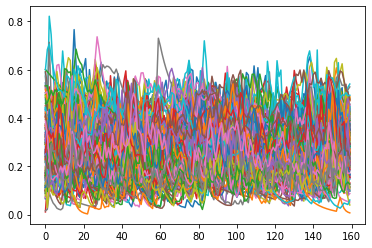

In [51]:
plt.plot(activity_scaled_cell_means['GRIN038_H13_M37_S23'])
plt.show()

In [41]:
# now i want to find the latency from the threshold crossing and sort the events in that manner 

In [42]:
threshold_pt = activity_scaled_cell_means.shape[0]/2

In [43]:
latency = activity_scaled_cell_means.idxmax(axis=0)
latency_flat = latency.reset_index()
latency_sorted = latency_flat.sort_values(by=0)

In [44]:
sorted_heatmap = np.empty([activity_scaled_cell_means.shape[1], activity_scaled_cell_means.shape[0]])

In [45]:
#activity_scaled_cell_means['GRIN035_H14_M40_S34'][49]

In [46]:
for row_idx in range(len(list(latency_sorted.index))):
    sorted_heatmap[row_idx] = activity_scaled_cell_means[latency_sorted.loc[list(latency_sorted.index)[row_idx]]['level_0']][latency_sorted.loc[list(latency_sorted.index)[row_idx]]['level_1']]
    

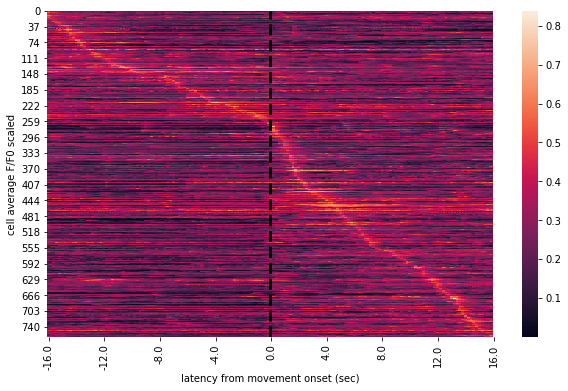

In [47]:
# heatmap

#fluorescence_events = np.transpose(sorted_heatmap)
X_labels = np.linspace(-16, 16, 161)
ax = sns.heatmap(sorted_heatmap, xticklabels=X_labels)
ax.set_xticks(ax.get_xticks()[::20])
ax.set_xticklabels(X_labels[::20])
fig = plt.gcf()
fig.set_size_inches(10, 6)
ax = plt.gca()
ax.set_ylabel('cell average F/F0 scaled')
ax.set_xlabel('latency from movement onset (sec)')
ax.axvline(x=(80), linestyle='--', lw=3, color='k')
#fig.subplots_adjust(left=0.15)
fig.savefig('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2021/cell_avg_aligned_heatmap_ko.pdf', transparent=True)
plt.show()


In [48]:
# save data to plot next to wt
latency_sorted[0].to_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2021/motion_onset_alignment/latency_to_movement_onset_KO.csv')

In [ ]:
KO_latency['0']

In [ ]:
#convert to seconds for display 
latency_sorted[0]*(.2)-(31.8/2)

In [ ]:
## plot a histogram of the latency to threshold
plt.hist(latency_sorted[0]*(.2)-(31.8/2), 50)
plt.hist(KO_latency['0']*(.2)-(31.8/2), 50, color='g')
fig = plt.gcf()
fig.set_size_inches(10, 6)
ax = plt.gca()
ax.set_ylabel('counts')
ax.set_xlabel('latency from/to movement onset (seconds)')
ax.axvline(x=(0), linestyle='--', lw=2, color='k')
fig.subplots_adjust(left=0.15)
fig.savefig('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/motion_onset_alignment/cumulative_latency_histogram.pdf', transparent=True)
plt.show()

In [ ]:
# plot cumulative histogram
cumulative_latency = stats.cumfreq(latency_sorted[0].values, numbins=100, defaultreallimits=(0, 160))
cumulative_latency_KO = stats.cumfreq(KO_latency['0'].values, numbins=100, defaultreallimits=(0, 160))

In [ ]:
#cumulative_latency

In [ ]:
cumulative_data = cumulative_latency.cumcount/len(latency_sorted[0].values)
cumulative_data_KO = cumulative_latency_KO.cumcount/len(KO_latency['0'].values)

In [ ]:
plt.rcParams.update({'font.size': 22})
plt.plot(np.linspace(-16, 16, 100), cumulative_data, linewidth=7.0)
plt.plot(np.linspace(-16, 16, 100), cumulative_data_KO, color='darkseagreen', linewidth=7.0)
plt.xlim((-16, 16))
fig = plt.gcf()
fig.set_size_inches(10, 6)
ax = plt.gca()
ax.set_ylabel('cumulative fraction')
ax.set_xlabel('latency from/to movement onset (seconds)')
ax.axvline(x=(0), linestyle='--', lw=2, color='k')
fig.subplots_adjust(left=0.15)
fig.savefig('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/motion_onset_alignment/cumulative_latency.pdf', transparent=True)
plt.show()

In [ ]:
stats.ks_2samp(cumulative_data, cumulative_data_KO)

In [ ]:
##average together by session 

In [ ]:
#concat by mouse 
concacted_by_mouse = {}
for mouse in list(set([session[0:7] for session in list(triggered_activity_across_sessions.keys())])):
    dfs_by_mouse = []
    sessions = []
    for session in list(triggered_activity_across_sessions.keys()):
        if mouse in session:
            if not(triggered_activity_across_sessions[session].empty):
                means = triggered_activity_across_sessions[session].mean(axis=1, level=0)
                dfs_by_mouse.append(means)
                sessions.append(session)
    if len(dfs_by_mouse)>0:
        concacted_by_mouse[mouse] = pd.concat(dfs_by_mouse, axis=1, keys=sessions)
combined_by_mouse = pd.concat(list(concacted_by_mouse.values()), axis=1, keys=list(concacted_by_mouse.keys()))

In [ ]:
combined_by_mouse_timedelta = combined_by_mouse.set_index(pd.to_timedelta(np.linspace(0, (len(combined_by_mouse)-1)*(1/5), len(combined_by_mouse)), unit='s'), drop=True)
resampled_for_plotting = combined_by_mouse_timedelta.resample('.4S').mean()

In [ ]:
#resampled_for_plotting.head()

In [ ]:
plt.rcParams.update({'font.size': 22})
df_to_plot = resampled_for_plotting
activity_measure = 'spatial_coordination'
x = np.linspace(-(len(df_to_plot)/2)*.4, (len(df_to_plot)/2)*.4, len(df_to_plot))
scale_f = 0.0868
mean=df_to_plot.mean(axis=1, level=2)['velocity'].values*scale_f
plt.plot(x, df_to_plot.mean(axis=1, level=2)['velocity'].values*scale_f, color='k')
std_error = ((df_to_plot.std(axis=1, level=2)['velocity'])/math.sqrt(df_to_plot.mean(axis=1, level=0).shape[1]))*scale_f
plt.fill_between(x, mean-std_error, mean+std_error)
ax = plt.gca()
ax.set_ylabel('velocity cm/sec')
ax.set_xlabel('time (seconds)')
ax.axvline(x=(0), linestyle='--', color='r')
fig = plt.gcf()
fig.set_size_inches(7, 6)
#fig.draw()
#fig.savefig('/home/jma819/presentation_files/wt_velocity_spatial_coord_triggered.svg', transparent=True)
fig.subplots_adjust(left=0.15)
fig.savefig('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/motion_onset_alignment/v_triggered.pdf', transparent=True)
plt.show()

In [ ]:
activity_measure = 'fluorescence'
x = np.linspace(-(len(df_to_plot)/2)*.4, (len(df_to_plot)/2)*.4, len(df_to_plot))
mean = df_to_plot.mean(axis=1, level=2)[activity_measure].values
plt.plot(x, mean, color='k')
std_error = (df_to_plot.std(axis=1, level=2)[activity_measure])/math.sqrt(df_to_plot.mean(axis=1, level=0).shape[1]*1)
plt.fill_between(x, mean-std_error, mean+std_error)
ax = plt.gca()
ax.set_ylabel('dF/F z-score')
ax.set_xlabel('time (seconds)')
ax.set_ylim([-0.02, 1.2])
ax.axvline(x=0, linestyle='--', color='r')
fig = plt.gcf()
fig.set_size_inches(7, 6)
#fig.draw()
#fig.savefig('.svg')
fig.subplots_adjust(left=0.15)
fig.savefig('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/motion_onset_alignment/wt_fluorescence_triggered.pdf', transparent=True)
plt.show()

## event ISIs 

In [ ]:
filtered_for_analysis = {}
for session in list(grouped_raw_data.keys()):
    filtered_for_analysis[session] = utils_jjm.filter_out_by_size(grouped_raw_data[session]['C_normalized_z_scored'], grouped_raw_data[session]['cell_contours'], 
                                                                  grouped_raw_data[session]['for_dims'], 0.6, 100)
C_df = pd.concat([filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))

In [ ]:
C_df = C_df.drop(['msCamFrame'], axis=1)

In [ ]:
ISIs_by_session = []
for session in list(grouped_raw_data.keys()):
    print(session)
    event_indicies, event_times, event_ISIs = utils_jjm.get_ISIs(C_df.loc[session].dropna(axis=1), 20, .1, np.array(C_df.loc[session].dropna(axis=1).columns), 2)
    ISIs_by_session.append(event_ISIs)